### Librerias y Funciones

In [0]:
spark.conf.set("spark.databricks.io.cache.enabled", True)
spark.conf.set('spark.sql.shuffle.partitions', 'auto')

In [0]:
%run ../../../../../04_utils/commons_functions_de

### Librerías

### Funciones Ingenieria de datos

### Funciones de ingesta en RDS

### Funciones de control de flujo de ingesta

In [0]:
%run ../../../../../04_utils/commons_functions_ds

In [0]:
%run ../../../../../spigot/initial/global_parameter_py

In [0]:
from IPython.display import display

# mute warnings
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pyspark.sql import Window
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import plotly.express as px

sns.set_theme(style="ticks")

from datetime import datetime
from dateutil.relativedelta import relativedelta

pd.set_option('display.float_format', lambda x: '%.5f' % x)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import regexp_extract

from datetime import datetime, date

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

#### Carga de Fuente

In [0]:
int_pedidos_clientes = (spark.read.parquet("/Volumes/dbw_prod_aavanzada/db_tmp/files/pburbano/data/")
                                  .withColumn("fecha_pedido_dt", F.to_date(F.col("fecha_pedido_dt")))
                        )

### Prediccion del Canal del Ultimo Pedido del Cliente

#### Creacion de MDT 

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import regexp_extract

# === 1. Definir ventanas ===
window_cliente = Window.partitionBy("cliente_id").orderBy("fecha_pedido_dt")

# === 2. Enriquecer DF base ===
df = int_pedidos_clientes.withColumn("fecha_ultimo_pedido", F.max("fecha_pedido_dt").over(Window.partitionBy("cliente_id")))
df = df.withColumn("canal_previo", F.lag("canal_pedido_cd").over(window_cliente))
df = df.withColumn("es_ultimo", F.when(F.col("fecha_pedido_dt") == F.col("fecha_ultimo_pedido"), 1).otherwise(0))

# === 3. Crear target multiclase (sin filtrar unicidad de pedidos en la última fecha) ===
df = df.withColumn(
    "target",
    F.when((F.col("canal_previo") != "DIGITAL") & (F.col("canal_pedido_cd") != "DIGITAL"), 0)
     .when((F.col("canal_previo") == "DIGITAL") & (F.col("canal_pedido_cd") == "DIGITAL"), 1)
     .when((F.col("canal_previo") != "DIGITAL") & (F.col("canal_pedido_cd") == "DIGITAL"), 2)
     .when((F.col("canal_previo") == "DIGITAL") & (F.col("canal_pedido_cd") != "DIGITAL"), 3)
)

# === 4. Filtrar último pedido con target válido ===
df_target = (
    df.filter("es_ultimo = 1")
      .filter(F.col("target").isNotNull())
      .select("cliente_id", "target", F.col("fecha_ultimo_pedido").alias("fecha_ultimo_pedido_target"))
)

# === 5. Crear histórico previo al último pedido ===
df_historico = (
    df.filter(F.col("es_ultimo") == 0)
      .join(df_target.select("cliente_id", "fecha_ultimo_pedido_target"), "cliente_id", "inner")
      .withColumn("dias_antes_ultimo", F.datediff("fecha_ultimo_pedido_target", "fecha_pedido_dt"))
      .withColumn("canal_pedido_cd", F.when(F.col("canal_pedido_cd") == "DIGITAL", "DIGITAL").otherwise("NO_DIGITAL"))
)

df_historico = df_historico.repartition("cliente_id").persist(StorageLevel.MEMORY_AND_DISK)

# === 6. Variables agregadas del histórico ===
# Pedidos y frecuencia
f_pedidos = df_historico.groupBy("cliente_id").agg(
    F.count("*").alias("n_pedidos_previos"),
    F.countDistinct("canal_pedido_cd").alias("n_canales_utilizados")
)

# calcular días entre pedidos
w_orden = Window.partitionBy("cliente_id").orderBy("fecha_pedido_dt")
df_historico = df_historico.withColumn(
    "dias_entre_pedidos", F.datediff("fecha_pedido_dt", F.lag("fecha_pedido_dt").over(w_orden))
)

# agregar canal previo y cambio de canal
df_historico = df_historico.withColumn("canal_previo", F.lag("canal_pedido_cd").over(w_orden))
df_historico = df_historico.withColumn(
    "cambio_canal", F.when(F.col("canal_previo") != F.col("canal_pedido_cd"), 1).otherwise(0)
)

# cambios hacia/desde digital
df_historico = df_historico.withColumn(
    "cambio_a_digital",
    F.when((F.col("canal_previo") != "DIGITAL") & (F.col("canal_pedido_cd") == "DIGITAL"), 1).otherwise(0)
)
df_historico = df_historico.withColumn(
    "cambio_desde_digital",
    F.when((F.col("canal_previo") == "DIGITAL") & (F.col("canal_pedido_cd") != "DIGITAL"), 1).otherwise(0)
)

# frecuencia de pedidos
f_frecuencia = df_historico.groupBy("cliente_id").agg(
    F.mean("dias_entre_pedidos").alias("dias_entre_pedidos_mean"),
    F.expr("percentile(dias_entre_pedidos, 0.5)").alias("dias_entre_pedidos_median"),
    F.min("dias_entre_pedidos").alias("dias_entre_pedidos_min"),
    F.max("dias_entre_pedidos").alias("dias_entre_pedidos_max")
)

# Conteo de cada canal
f_canales = df_historico.groupBy("cliente_id").pivot("canal_pedido_cd").count().fillna(0)
if "DIGITAL" not in f_canales.columns:
    f_canales = f_canales.withColumn("DIGITAL", F.lit(0))
if "NO_DIGITAL" not in f_canales.columns:
    f_canales = f_canales.withColumn("NO_DIGITAL", F.lit(0))
f_canales = (
    f_canales.withColumnRenamed("DIGITAL", "n_digital")
             .withColumnRenamed("NO_DIGITAL", "n_no_digital")
             .withColumn(
                 "prop_digital",
                 F.when(
                     (F.col("n_digital") + F.col("n_no_digital")) > 0,
                     F.col("n_digital") / (F.col("n_digital") + F.col("n_no_digital"))
                 ).otherwise(0)
             )
)

# variables numericas
f_valores = (
    df_historico.groupBy("cliente_id").agg(
        F.sum("facturacion_usd_val").alias("facturacion_total"),
        F.avg("facturacion_usd_val").alias("facturacion_prom"),
        F.stddev("facturacion_usd_val").alias("facturacion_std"),
        F.sum("materiales_distintos_val").alias("materiales_distintos_total"),
        F.avg("materiales_distintos_val").alias("materiales_prom"),
        F.stddev("materiales_distintos_val").alias("materiales_std"),
        F.sum("cajas_fisicas").alias("cajas_fisicas_total"),
        F.avg("cajas_fisicas").alias("cajas_fisicas_prom"),
        F.stddev("cajas_fisicas").alias("cajas_fisicas_std"),
    )
    .fillna(0, subset=["facturacion_std", "materiales_std", "cajas_fisicas_std"])
)

# variables que no cambian en el tiempo
f_variables_fijas = (
    df_historico.groupBy("cliente_id").agg(
        F.first("pais_cd").alias("pais_cd"),
        F.first("region_comercial_txt").alias("region_comercial_txt"),
        F.first("tipo_cliente_cd").alias("tipo_cliente_cd"),
        F.first("madurez_digital_cd").alias("madurez_digital_val"),
        F.first("estrellas_txt").cast("int").alias("estrellas_val"),
        F.length(F.first("frecuencia_visitas_cd")).alias("frecuencia_visitas_val"),
        F.first("fecha_ultimo_pedido_target").cast("timestamp").alias("fecha_ultimo_pedido"),
    )
)

# informacion de agencia y ruta
df_historico = (
    df_historico.withColumn("agencia_num", regexp_extract(F.col("agencia_id"), r"A(\d+)$", 1).cast("int"))
                 .withColumn("ruta_num", regexp_extract(F.col("ruta_id"), r"R(\d+)$", 1).cast("int"))
)

f_ruta_agencia = (
    df_historico.groupBy("cliente_id").agg(
        F.first("agencia_num").alias("agencia_num"),
        F.first("ruta_num").alias("ruta_num")
    )
)

# === MDT FINAL ===
df_mdt = (
    f_pedidos
    .join(f_canales, "cliente_id", "left")
    .join(f_valores, "cliente_id", "left")
    .join(f_frecuencia, "cliente_id", "left")
    .join(f_ruta_agencia, "cliente_id", "left")
    .join(f_variables_fijas, "cliente_id", "left")
    .join(df_target.select("cliente_id", "target"), "cliente_id", "inner")
)


#### Modelamiento

In [0]:
df_mdt_pd = df_mdt.toPandas()

#### Division Train / Test

In [0]:
df_features_pd = df_mdt_pd.copy()

df_features_pd = df_features_pd.fillna(0)

# dividir en train y test
df_features_pd["fecha_ultimo_pedido"] = df_features_pd["fecha_ultimo_pedido"].dt.date
df_train = df_features_pd[df_features_pd["fecha_ultimo_pedido"] < date(2024,8,1)]
df_test = df_features_pd[df_features_pd["fecha_ultimo_pedido"] >= date(2024,8,1)]

##### Validacion de balance en muestras y target

In [0]:
# proporcion train/test
df_test.shape[0] / (df_test.shape[0] + df_train.shape[0])

0.2737038952771257

In [0]:
# proporcion de target en train
df_train["target"].value_counts(normalize=True)

target
0   0.29075
1   0.25120
3   0.22947
2   0.22858
Name: proportion, dtype: float64

In [0]:
# proporcion de target en test
df_test["target"].value_counts(normalize=True)

target
0   0.28929
1   0.25067
2   0.23201
3   0.22804
Name: proportion, dtype: float64

##### LightGBM

In [0]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

# === Creación de conjuntos de entrenamiento y prueba ===
cols_exclude = ["cliente_id", "fecha_ultimo_pedido", "target"]

X_train = df_train.copy().drop(cols_exclude, axis=1)
X_test = df_test.copy().drop(cols_exclude, axis=1)

y_train = df_train.copy()["target"]
y_test = df_test.copy()["target"]

# === Tratamiento adicional de categóricas ===
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# === Modelo multiclass con parámetros regularizados ===
n_classes = y_train.nunique()

model = LGBMClassifier(
    objective="multiclass",
    num_class=n_classes,
    learning_rate=0.01,
    n_estimators=1200,
    num_leaves=31,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3.0,
    reg_lambda=3.0,
    min_child_samples=150,
    class_weight="balanced",
    random_state=2022
)

# === Callbacks para early stopping y logging ===
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.log_evaluation(period=0)
]

# === Entrenamiento del modelo ===
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="multi_logloss",
    callbacks=callbacks,
    categorical_feature=categorical_cols
)

# === Predicción y evaluación ===
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("Entrenamiento multiclase completado. Clases detectadas:", model.classes_)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3475
[LightGBM] [Info] Number of data points in the train set: 109524, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with

##### Metricas Train

In [0]:
# === Predicciones ===
y_pred = model.predict(X_train)
y_pred_proba = model.predict_proba(X_train)
classes = model.classes_

# === Matriz de Confusión ===
print("Matriz de Confusión:")
print(confusion_matrix(y_train, y_pred))

# === Clasificación general ===
print("\nClassification Report:")
print(classification_report(y_train, y_pred))

# === Balanced Accuracy ===
balanced_acc = balanced_accuracy_score(y_train, y_pred)
print("\nBalanced Accuracy:", round(balanced_acc, 4))

# === ROC AUC Multiclase ===
# Binarizar labels para calcular AUC multiclase
y_train_bin = label_binarize(y_train, classes=classes)

auc_macro = roc_auc_score(y_train_bin, y_pred_proba, average="macro", multi_class="ovr")
auc_weighted = roc_auc_score(y_train_bin, y_pred_proba, average="weighted", multi_class="ovr")

print("ROC AUC Macro:", round(auc_macro, 4))
print("ROC AUC Weighted:", round(auc_weighted, 4))

# === Gini Coefficient ===
# Gini = 2 * AUC - 1
gini_macro = 2 * auc_macro - 1
gini_weighted = 2 * auc_weighted - 1

print("Gini Macro:", round(gini_macro, 4))
print("Gini Weighted:", round(gini_weighted, 4))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Matriz de Confusión:
[[18666  3224  5318  4636]
 [ 3268 16292  4114  3838]
 [ 9943  5329  7063  2700]
 [ 5918  8607  3288  7320]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.59      0.54     31844
           1       0.49      0.59      0.53     27512
           2       0.36      0.28      0.32     25035
           3       0.40      0.29      0.34     25133

    accuracy                           0.45    109524
   macro avg       0.43      0.44      0.43    109524
weighted avg       0.44      0.45      0.44    109524


Balanced Accuracy: 0.4379
ROC AUC Macro: 0.7232
ROC AUC Weighted: 0.7264
Gini Macro: 0.4465
Gini Weighted: 0.4529


##### Metricas Test

In [0]:
# === Predicciones ===
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
classes = model.classes_

# === Matriz de Confusión ===
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# === Clasificación general ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# === Balanced Accuracy ===
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("\nBalanced Accuracy:", round(balanced_acc, 4))

# === ROC AUC Multiclase ===
# Binarizar labels para calcular AUC multiclase
y_test_bin = label_binarize(y_test, classes=classes)

auc_macro = roc_auc_score(y_test_bin, y_pred_proba, average="macro", multi_class="ovr")
auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, average="weighted", multi_class="ovr")

print("ROC AUC Macro:", round(auc_macro, 4))
print("ROC AUC Weighted:", round(auc_weighted, 4))

# === Gini Coefficient ===
# Gini = 2 * AUC - 1
gini_macro = 2 * auc_macro - 1
gini_weighted = 2 * auc_weighted - 1

print("Gini Macro:", round(gini_macro, 4))
print("Gini Weighted:", round(gini_weighted, 4))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Matriz de Confusión:
[[6922 1317 1951 1750]
 [1342 6026 1628 1350]
 [3852 2196 2491 1037]
 [2439 3265 1301 2407]]

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.58      0.52     11940
           1       0.47      0.58      0.52     10346
           2       0.34      0.26      0.29      9576
           3       0.37      0.26      0.30      9412

    accuracy                           0.43     41274
   macro avg       0.41      0.42      0.41     41274
weighted avg       0.42      0.43      0.42     41274


Balanced Accuracy: 0.4195
ROC AUC Macro: 0.6979
ROC AUC Weighted: 0.7013
Gini Macro: 0.3958
Gini Weighted: 0.4026


##### Analisis de Caracteristicas

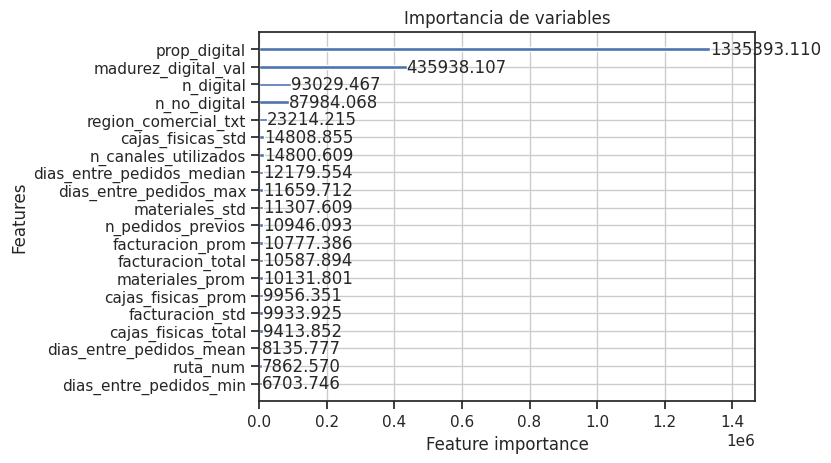

In [0]:
# importancia de caracteristicas
lgb.plot_importance(model, max_num_features=20, importance_type='gain') 
plt.title("Importancia de variables")
plt.show()

##### Analisis por segmentos de madurez

In [0]:
df_test_2 = df_test.copy()
df_test_2["madurez_digital_val"] = df_mdt_pd.loc[df_test_2.index, "madurez_digital_val"].values

# Evaluar por cada nivel de madurez
for nivel in df_test_2["madurez_digital_val"].dropna().unique():
    subset = df_test_2[df_test_2["madurez_digital_val"] == nivel]
    X_seg = X_test.loc[subset.index]
    y_seg = y_test.loc[subset.index]
    
    preds_proba = model.predict_proba(X_seg)[:, 1]
    preds_bin = (preds_proba >= 0.5).astype(int)
    
    auc = roc_auc_score(y_seg, preds_proba)
    cm = confusion_matrix(y_seg, preds_bin)
    
    print(f"\n=== {nivel} ===")
    print(f"AUC: {auc:.4f}")
    print("Matriz de confusión:")
    print(cm)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

=== BAJA ===
AUC: 0.4948
Matriz de confusión:
[[10998  2099]
 [ 6049  1141]]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

=== ALTA ===
AUC: 0.5000
Matriz de confusión:
[[ 111 1374]
 [ 301 4261]]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

=== MEDIA ===
AUC: 0.5000
Matriz de confusión:
[[2545 3913]
 [3092 4788]]
